In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

In [2]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [3]:
#file_index='BBBSBBBB'
file_index='SBBBSBSS'
data_dir='../../Data/Weather'

filebase='US_Weather_%s'%file_index
!rm -rf $data_dir/$filebase*

c_filename=filebase+'.csv.gz'
u_filename=filebase+'.csv'

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/small/%s > %s/%s"%(c_filename,data_dir,c_filename)
print command
!$command
!ls -lh $data_dir/$c_filename

curl https://mas-dse-open.s3.amazonaws.com/Weather/small/US_Weather_SBBBSBSS.csv.gz > ../../Data/Weather/US_Weather_SBBBSBSS.csv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3635k  100 3635k    0     0  3691k      0 --:--:-- --:--:-- --:--:-- 4256k
-rw-r--r--  1 collinli  staff   3.5M May 15 13:35 ../../Data/Weather/US_Weather_SBBBSBSS.csv.gz


In [4]:
#unzip
!gunzip -c $data_dir/$c_filename > $data_dir/$u_filename
import pickle
List=pickle.load(open(data_dir+'/'+u_filename,'rb'))
len(List)

12351

In [5]:
df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

12351
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|     2|[80 54 90 55 00 5...|1908.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    25|[00 CF F0 56 90 5...|1909.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    29|[80 C9 00 7E 00 7...|1910.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    37|[00 7E 00 7E 80 4...|1911.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    40|[E0 D5 00 7E E0 D...|1912.0|SBBBSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [6]:
#store dataframe as parquet file
outfilename=data_dir+'/'+filebase+'.parquet'
!rm -rf $outfilename
df.write.save(outfilename)

In [7]:
# Compare file sizes
!du -sh $data_dir/$filebase*
from time import time
t=time()

N=sc.defaultParallelism
print 'Number of executors=',N
print 'took',time()-t,'seconds'

 12M	../../Data/Weather/US_Weather_SBBBSBSS.csv
3.6M	../../Data/Weather/US_Weather_SBBBSBSS.csv.gz
4.5M	../../Data/Weather/US_Weather_SBBBSBSS.parquet
Number of executors= 3
took 0.00158786773682 seconds


In [8]:
measurements=['TMAX','TMIN','TDIFF']

In [9]:
sqlContext.registerDataFrameAsTable(df,'weather') #using older sqlContext instead of newer (V2.0) sparkSession

In [10]:
Query="SELECT DISTINCT station,year FROM weather WHERE measurement = 'TMAX'"
df1 = sqlContext.sql(Query)
l1 = df1.rdd.collect()

#initialize df_concat
Query3="SELECT * FROM weather\n\tWHERE measurement = 'TMAX' AND station = '%s' AND year='%f'"%(l1[0][0],l1[0][1])
df3 = sqlContext.sql(Query3)
df_concat = df3.union(df3)

c = 0
for l in l1:
    Query3="SELECT * FROM weather\n\tWHERE measurement = 'TMAX' AND station = '%s' AND year='%f'"%(l[0],l[1])
    Query4="SELECT * FROM weather\n\tWHERE measurement = 'TMIN' AND station = '%s' AND year='%f'"%(l[0],l[1])
    df3 = sqlContext.sql(Query3)
    df4 = sqlContext.sql(Query4)
    if df3.count() != 0 and df4.count() != 0:
        data3=df3.rdd.map(lambda row: unpackArray(row['vector'],np.float16)).collect()
        data4=df4.rdd.map(lambda row: unpackArray(row['vector'],np.float16)).collect()
        data5 = np.array(data3) - np.array(data4)
        data6 = packArray(data5)
        temp = df3.rdd.map(lambda r: r).collect()
        
        df5 = sqlContext.createDataFrame([(temp[0]['elevation'],temp[0]['latitude'],temp[0]['longitude'],\
                                    "TDIFF",temp[0]['station'],temp[0]['undefs'],data6,temp[0]['year'],\
                                    temp[0]['label'])])
        
        df_concat = df_concat.union(df5)
        c += 1
        print(c)
        #200 is suggested based on the memory of computers.  However, 2368 is used when writing report.
        if c == 200:
            break


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [11]:
STAT = {}
data7=df_concat.rdd.filter(lambda r: r['measurement'] == "TDIFF")
print(len(data7.collect()))
data8=data7.map(lambda row: unpackArray(row['vector'],np.float16))

200


In [12]:
from numpy import linalg as LA
STAT["TDIFF"]=computeOverAllDist(data8)
# compute covariance matrix
    
OUT=computeCov(data8)

#find PCA decomposition
eigval,eigvec=LA.eig(OUT['Cov'])

# collect all of the statistics in STAT[meas]
STAT["TDIFF"]['eigval']=eigval
STAT["TDIFF"]['eigvec']=eigvec
STAT["TDIFF"].update(OUT)

shape of E= (365,) shape of NE= (365,)


In [13]:
from pickle import dump
filename=data_dir+'/STAT_%s.pickle'%file_index
dump((STAT,STAT_Descriptions),open(filename,'wb'))

In [14]:
rows=data7.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
np.shape(T)

(200, 365)

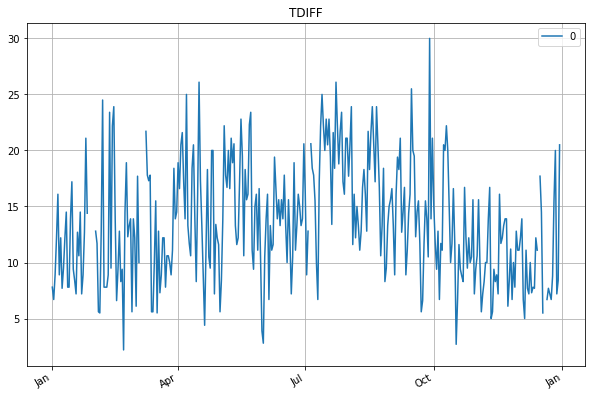

In [15]:
import matplotlib.pyplot as plt
import sys
sys.path.append('./lib')
import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:1,:].transpose(),fig,ax,title='TDIFF')
plt.show()

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


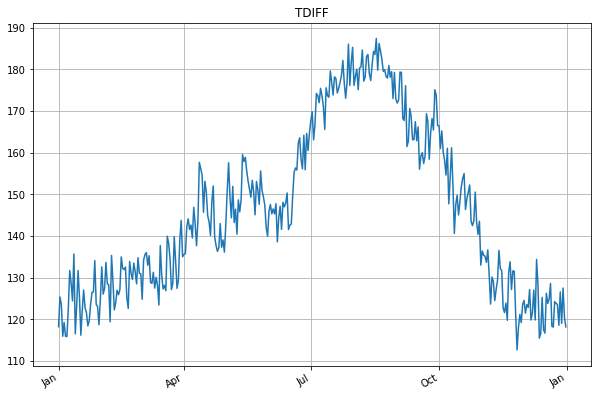

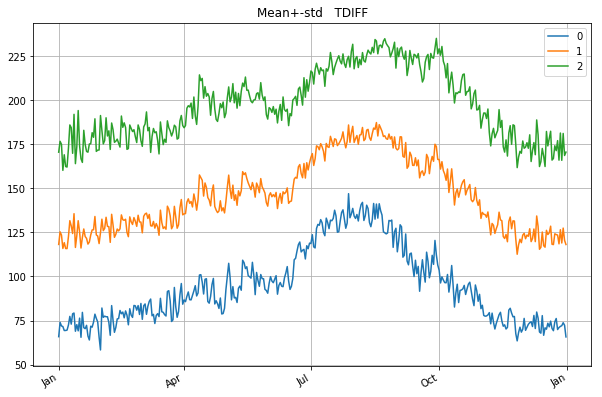

In [16]:
diff = STAT['TDIFF']['Mean']
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(diff,fig,ax,title='TDIFF')
plt.show()

mean=STAT['TDIFF']['Mean']
std=np.sqrt(STAT['TDIFF']['Var'])
fig, axis = plt.subplots(figsize=(10,7));
graphs=np.vstack([mean-std,mean,mean+std]).transpose()
YP.plot(graphs,fig,axis,title='Mean+-std   '+'TDIFF')
plt.show()

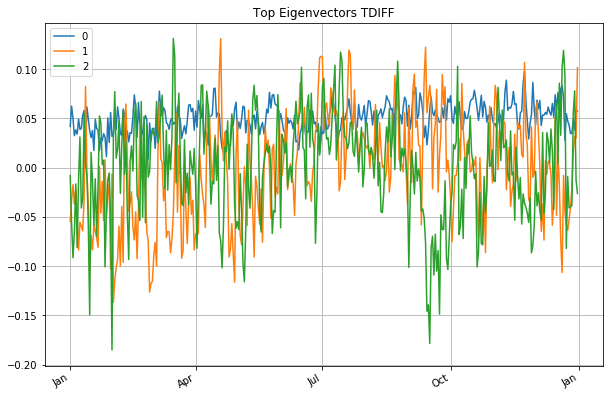

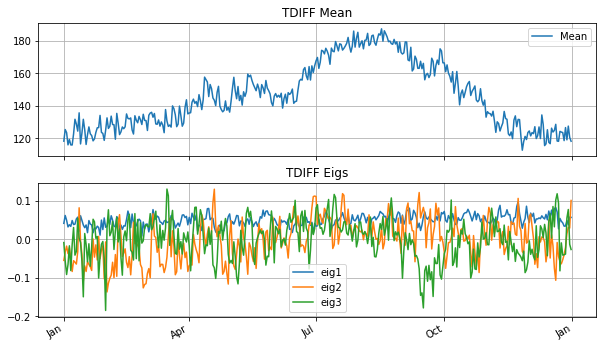

In [17]:
fig, axis = plt.subplots(figsize=(10,7));
EV=STAT['TDIFF']['eigvec']
YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+'TDIFF')
plt.show()

fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT['TDIFF']['eigvec'][:,:k])
Mean=STAT['TDIFF']['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title='TDIFF'+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title='TDIFF'+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
plt.show()

In [18]:
def pltVarExplained(j):
    plt.subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plt.plot(([0,]+list(np.cumsum(EV[:k])))/sum(EV))
    plt.title('Percentage of Variance Explained for '+ m)
    plt.ylabel('Percentage of Variance')
    plt.xlabel('# Eigenvector')
    plt.grid()

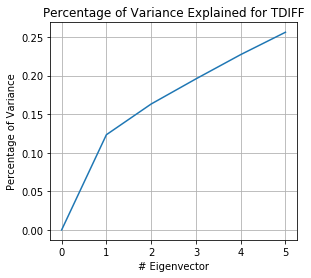

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TDIFF']: #,
    pltVarExplained(j)
    j+=1
plt.show()

In [20]:
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot
from import_modules import import_modules,modules
import_modules(modules)
from ipywidgets import interactive,widgets

i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],np.zeros(365),v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0
residual normalized norm  after mean: 1.0
residual normalized norm  after mean + top eigs: [ 0.14244084  0.14227722  0.13765436]


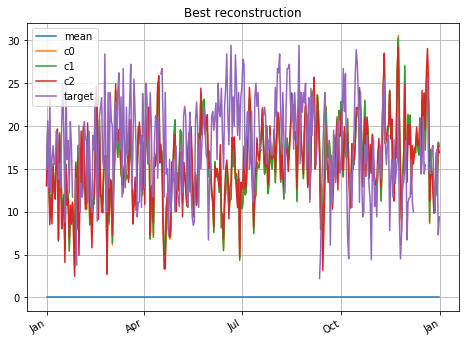

Widget Javascript not detected.  It may not be installed or enabled properly.


In [21]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
plotter.get_Interactive()

In [23]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [24]:
rows=df_concat.take(3)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.363740230872 res_1 : 0.921637250204 res_2 : 0.78090540883 res_3 : 0.771425270346
res_mean : 0.363740230872 res_1 : 0.921637250204 res_2 : 0.78090540883 res_3 : 0.771425270346
res_mean : 0.108570920296 res_1 : 0.950641619842 res_2 : 0.95063794229 res_3 : 0.948687418343


In [25]:
rdd11 = df_concat.rdd
Series=rdd11.map(lambda row: np.array(unpackArray(row['vector'],np.float16),dtype=np.float64))
series = Series.collect()

In [35]:
#initialize df_res
s_tmp = series[0]
recon = Eigen_decomp(None,s_tmp,np.zeros(365),v)
total_var,residuals,reductions,coeff=recon.compute_var_explained()
#print coeff
residuals=[float(r) for r in residuals[1]]
coeff=[float(r) for r in coeff[1]]
D=row.asDict()
D['total_var']=float(total_var[1])
D['res_mean']=residuals[0]
for i in range(1,len(residuals)):
    D['res_'+str(i)]=residuals[i]
    D['coeff_'+str(i)]=coeff[i-1]
    tmp = sqlContext.createDataFrame([Row(**D)])
    df_res = tmp.union(tmp)
    
for s in series:
    recon = Eigen_decomp(None,s,np.zeros(365),v)
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    tmp = sqlContext.createDataFrame([Row(**D)])
    df_res = df_res.union(tmp)

In [29]:
df_tdiff = df_concat.rdd.filter(lambda r: r['measurement'] == 'TDIFF')
df_new = sqlContext.createDataFrame(df_tdiff)
df_new.show(10)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1463.0|    46.5|-110.3378|      TDIFF|USC00245387|    11|[E0 54 30 54 90 5...|1951.0|SBBBSBSS|
|    926.9|    46.5|-107.3167|      TDIFF|USC00244384|     6|[00 7E B8 59 00 7...|1942.0|SBBBSBSS|
|    851.9| 46.7392|-107.2078|      TDIFF|USC00244386|    13|[B0 58 70 5A 00 5...|1961.0|SBBBSBSS|
|    808.0| 47.5667|   -106.7|      TDIFF|USC00244007|     9|[80 58 30 58 38 5...|1975.0|SBBBSBSS|
|    808.0| 47.5667|   -106.7|      TDIFF|USC00244007|    15|[00 7E E0 55 F0 5...|1988.0|SBBBSBSS|
|   1981.2| 46.7333|-109.5667|      TDIFF|USC00243389|    49|[00 7E 00 7E A0 5...|1911.0|SBBBSBSS|
|   2258.6|    46.9|  -110.85|      TDIFF|USS0010C22S|     7|[90 54 30 54 E0 5...|2003.0|SBBBSBSS|
|    775.1

In [30]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [36]:
#df_res_sort=df_res.sort(df_res.res_3,ascending=True)
#rows=df_res_sort.take(12)
#df_res_sort.select('res_mean','res_1','res_2','res_3').show(4)

rows=df_res.take(12)

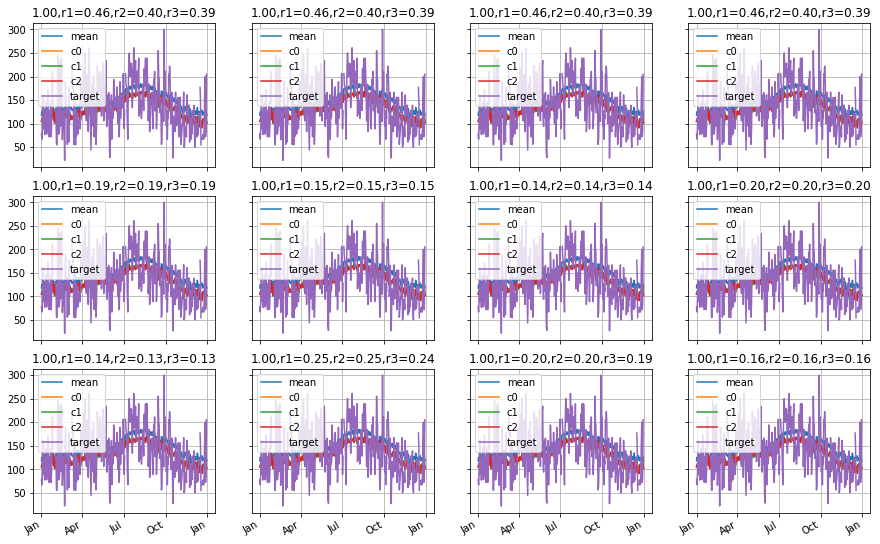

In [38]:
plot_recon_grid(rows)
plt.show()